# CoinGame solver using multi-agent advantage actor-critic (MAA2C) with a shared classical policy and joint classical critic.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path
import json

2024-03-27 12:39:48.299209: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [4]:
metrics_file = Path("./output/coingame_maa2c_classical_small.json")

metrics_file.parent.expanduser().mkdir(parents=True, exist_ok=True)

In [5]:
n_actions = 4
n_agents = 2
observation_dim = 36

In [6]:
import numpy as np


def generate_model_actor_classical(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    # layers += [keras.layers.Input(shape=(observation_dim,), sparse=True)]
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model

def generate_model_critic_classical(units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    # layers += [keras.layers.Input(shape=(n_agents, observation_dim,), sparse=True)]
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [7]:
# Shared actor.
model_actor = generate_model_actor_classical(
    n_actions=n_actions,
    # units=[16, 8],
    units=[12],
    name=f"actor-classical-shared"
    )
optimizer_actor = keras.optimizers.Adam(learning_rate=1e-3)

model_actor.build((None, observation_dim))
model_actor.summary()

Model: "actor-classical-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 12)                444       
                                                                 
 policy (Dense)              (None, 4)                 52        
                                                                 
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Classical critic.
model_critic = generate_model_critic_classical(
    # units=[16, 8],
    units=[12],
    name=f"critic-classical-joint"
    )
optimizer_critic = keras.optimizers.Adam(learning_rate=1e-3)

model_critic.build((None, n_agents, observation_dim))
model_critic.summary()

Model: "critic-classical-joint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                876       
                                                                 
 v (Dense)                   (None, 1)                 13        
                                                                 
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________


## Training

In [9]:
gamma = 0.99
alpha = 0.001
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
    'time_limit': 50,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    episode_metrics_callback=episode_metrics_callback,
    )

In [23]:
s, _ = env.reset()
s = s.reshape((n_agents,4,3,3))
s[0,:,:]

array([[[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [108]:
# 2**(1-tf.range(s.shape[-1], dtype=s.dtype))

def encode(s):
    i = -tf.range(s.shape[-1], dtype=s.dtype)
    es = tf.math.reduce_sum(s[:,:,:] * 2**i, axis=-1)
    return es

def map_observable_to_vector(obs: tf.Tensor) -> tf.Tensor:
    i = -tf.range(obs.shape[-1], dtype=obs.dtype) # Power of 2 that represents the column within the grid.
    return tf.math.reduce_sum(obs * (2**i), axis=-1)

def old_map_observable_to_vector(obs: tf.Tensor) -> tf.Tensor:
    """Converts an observable with shape `(...,x,y)` into `(...,x)` where the final dimension `y` is represented as a `sum({grid_y_val} * 2^{grid_y_length - grid_y_index})` for every column in all rows."""
    b = 2**tf.range(obs.shape[-1], dtype=obs.dtype) # Power of 2 that represents the column within the grid.
    return tf.tensordot(obs[...,::-1], b[::-1], 1)

In [109]:
encode(s), map_observable_to_vector(s), old_map_observable_to_vector(s)

(<tf.Tensor: shape=(2, 4, 3), dtype=float64, numpy=
 array([[[0.  , 0.  , 0.25],
         [1.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.  ],
         [0.  , 0.  , 0.  ]],
 
        [[1.  , 0.  , 0.  ],
         [0.  , 0.  , 0.25],
         [0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.  ]]])>,
 <tf.Tensor: shape=(2, 4, 3), dtype=float64, numpy=
 array([[[0.  , 0.  , 0.25],
         [1.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.  ],
         [0.  , 0.  , 0.  ]],
 
        [[1.  , 0.  , 0.  ],
         [0.  , 0.  , 0.25],
         [0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.  ]]])>,
 <tf.Tensor: shape=(2, 4, 3), dtype=float64, numpy=
 array([[[0., 0., 4.],
         [1., 0., 0.],
         [2., 0., 0.],
         [0., 0., 0.]],
 
        [[1., 0., 0.],
         [0., 0., 4.],
         [0., 0., 0.],
         [2., 0., 0.]]])>)

In [110]:
a = np.random.choice(4, size=(2,))
tup = env.step(a)
s = tup[0].reshape((n_agents,4,3,3))
a, encode(s), tup

(array([2, 0]),
 <tf.Tensor: shape=(2, 4, 3), dtype=float64, numpy=
 array([[[0.  , 0.25, 0.  ],
         [0.5 , 0.  , 0.  ],
         [0.  , 0.25, 0.  ],
         [0.  , 0.  , 0.  ]],
 
        [[0.5 , 0.  , 0.  ],
         [0.  , 0.25, 0.  ],
         [0.  , 0.  , 0.  ],
         [0.  , 0.25, 0.  ]]])>,
 (array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0.]]),
  array([-2.,  1.]),
  array([False, False]),
  array([False, False]),
  {'neighbor_agents': [[1], [0]]}))

In [114]:
s[0], np.sum(s[0], axis=-1)

(array([[[0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 0.]],
 
        [[0., 1., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]),
 array([[0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]]))

In [105]:
import cirq

a = np.random.choice(4, size=(2,))
env.reset()
tup = env.step(a)
s = tup[0].reshape((n_agents,4,3,3))

theta = map_observable_to_vector(s)

qubits = cirq.LineQubit.range(4)
circuit = cirq.Circuit([
    [cirq.rx(theta[0, q, 0])(qubit), cirq.ry(theta[0, q, 1])(qubit), cirq.rz(theta[0, q, 2])(qubit)]
    for q, qubit in enumerate(qubits)
])

circuit, theta

(0: ───Rx(0)────────Ry(0)───Rz(0.0796π)───

1: ───Rx(0.318π)───Ry(0)───Rz(0)─────────

2: ───Rx(0.159π)───Ry(0)───Rz(0)─────────

3: ───Rx(0)────────Ry(0)───Rz(0)─────────,
 <tf.Tensor: shape=(2, 4, 3), dtype=float64, numpy=
 array([[[0.  , 0.  , 0.25],
         [1.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.  ],
         [0.  , 0.  , 0.  ]],
 
        [[1.  , 0.  , 0.  ],
         [0.  , 0.  , 0.25],
         [0.  , 0.  , 0.  ],
         [0.5 , 0.  , 0.  ]]])>)

In [10]:
# Train models using algorithm.
reward_history, metrics_history = algo.train(n_episodes=3000)

# Save results to file.
algo.save_train_results(metrics_file, reward_history, metrics_history)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 0:   0%|          | 0/3000 [00:00<?, ?episode/s]

Episode 3000: 100%|██████████| 3000/3000 [06:51<00:00,  7.30episode/s, coins_collected=28, discounted_reward=21.8, episode_reward=[18. 10.], own_coin_rate=1, own_coins_collected=28, undiscounted_reward=28]    


In [11]:
# Load metrics from file.
reward_history, metrics_history = algo.load_train_results(metrics_file)

Text(0.5, 1.0, 'Score')

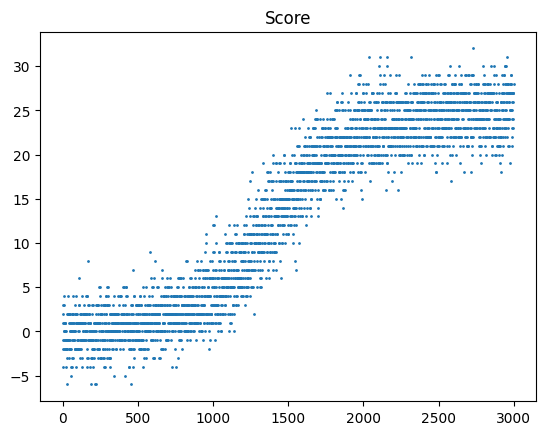

In [12]:
score = np.sum(reward_history, axis=-1)
# plt.plot(score)
plt.scatter(list(range(len(score))), score, s=1)
plt.title('Score')

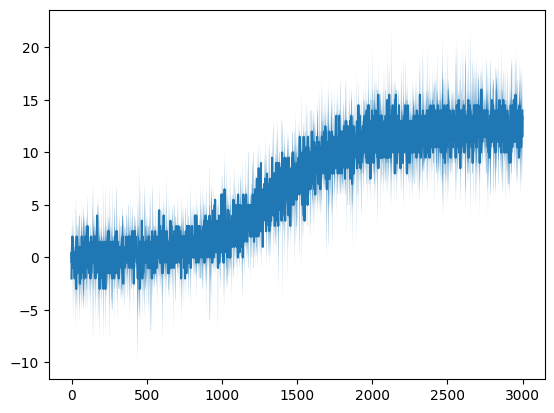

In [13]:
reward_history_mean = np.mean(reward_history, axis=-1)
reward_history_std = np.std(reward_history, axis=-1)
x = np.arange(len(reward_history_mean))
plt.plot(x, reward_history_mean)
plt.fill_between(x, reward_history_mean + reward_history_std, reward_history_mean - reward_history_std)

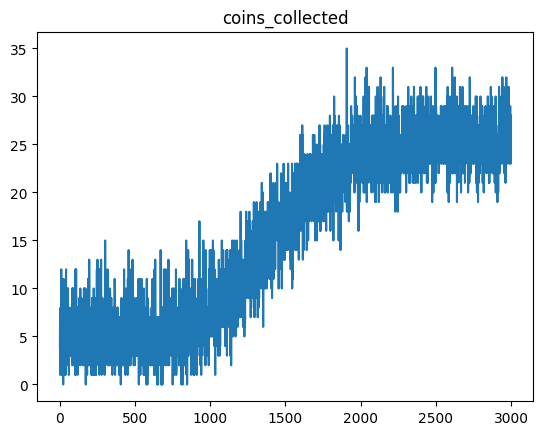

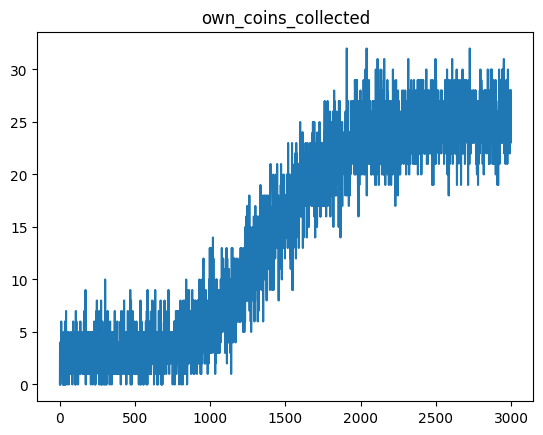

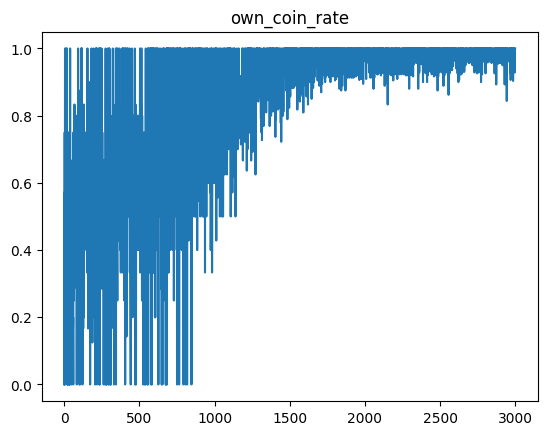

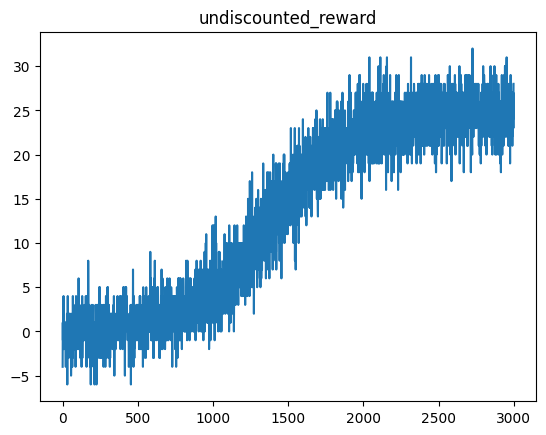

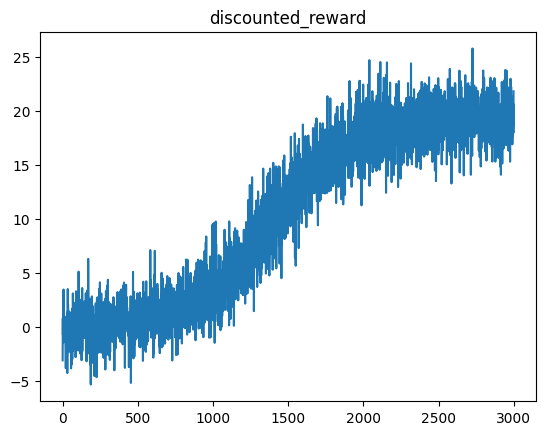

In [14]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v)